In [ ]:
import sys
import os
sys.path.append(os.path.abspath(".."))


from Models.linear_model import LinearStateSpaceModel
from Filters.linear_kalman  import LinearKalmanFilter
from Filters.ukf  import UnscentedKalmanFilter
from Filters.particle import ParticleFilter

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [3]:
np.random.seed(123)

d = 2   # dimensión estado
m = 1   # dimensión observación
T = 50

A = np.array([[1.0, 0.1],
              [0.0, 1.0]])

H = np.array([[1.0, 0.0]])

Sigma = 0.01 * np.eye(d)
Gamma = 0.1 * np.eye(m)


In [4]:
def simulate_lgssm(A, H, Sigma, Gamma, x0, T):
    d = len(x0)
    m = H.shape[0]

    X = np.zeros((T + 1, d))
    Y = np.zeros((T, m))

    X[0] = x0
    for t in range(T):
        X[t + 1] = A @ X[t] + np.random.multivariate_normal(np.zeros(d), Sigma)
        Y[t] = H @ X[t + 1] + np.random.multivariate_normal(np.zeros(m), Gamma)

    return X, Y

x0 = np.array([0.0, 1.0])
X_true, Y = simulate_lgssm(A, H, Sigma, Gamma, x0, T)


In [5]:

def A_fn(theta): return A
def H_fn(theta): return H
def Sigma_fn(theta): return Sigma
def Gamma_fn(theta): return Gamma

def Phi(x, theta):
    return A @ x

def h(x, theta):
    return H @ x

def prior_logpdf(theta):
    return 0.0  # fijo para benchmarking

m0 = np.zeros(d)
P0 = np.eye(d)
theta = None


In [6]:
t0 = time.time()

kf = LinearKalmanFilter(
    theta, m0, P0, prior_logpdf,
    A_fn, H_fn, Sigma_fn, Gamma_fn
)


kf_res = kf.filter(Y)
kf_time = time.time() - t0


In [7]:
kf_res

{'log_prior': 0.0,
 'log_likelihood': np.float64(-29.205759990302337),
 'log_posterior': np.float64(-29.205759990302337),
 'prediction': (array([7.64087785, 2.22346979]),
  array([[0.03316331, 0.025858  ],
         [0.025858  , 0.1282876 ]]))}

In [8]:


t0 = time.time()

ukf = UnscentedKalmanFilter(
    theta, m0, P0, prior_logpdf,
    Phi, h, Sigma_fn, Gamma_fn
)

ukf_res = ukf.filter(Y)

ukf_time = time.time() - t0

In [9]:
ukf_res

{'log_prior': 0.0,
 'log_likelihood': np.float64(-29.20576322913742),
 'log_posterior': np.float64(-29.20576322913742),
 'prediction': (array([7.64087778, 2.22346973]),
  array([[0.03316329, 0.02585799],
         [0.02585799, 0.12828748]]))}

In [10]:
t0 = time.time()

pf = ParticleFilter(
    theta, N=100000,
    m0=m0, P0=P0,
    prior_logpdf=prior_logpdf,
    Phi=Phi, h=h,
    Sigma_fn=Sigma_fn,
    Gamma_fn=Gamma_fn
)

pf_res = pf.filter(Y)

pf_time = time.time() - t0

In [11]:
pf_res

{'log_prior': 0.0,
 'log_likelihood': np.float64(-29.31459745845057),
 'log_posterior': np.float64(-29.31459745845057),
 'prediction': (array([7.63881469, 2.22079661]),
  array([[0.03311283, 0.0262315 ],
         [0.0262315 , 0.13031269]])),
 'particles': array([[6.99380097, 1.15627244],
        [7.41742918, 1.56285262],
        [7.15704367, 2.04063058],
        ...,
        [8.24953558, 2.49046057],
        [7.66644189, 2.68223172],
        [7.70824959, 2.83749222]], shape=(100000, 2)),
 'weights': array([7.86723362e-08, 1.24181146e-05, 3.86628233e-07, ...,
        2.37836974e-06, 2.67455940e-05, 2.61639307e-05], shape=(100000,))}

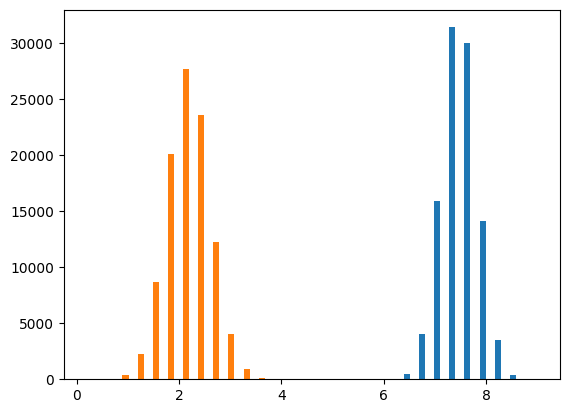

In [20]:
plt.hist(pf_res['particles'],bins=30)
plt.show()

In [12]:
def rmse(x_hat, x_true):
    return np.sqrt(np.mean((x_hat - x_true)**2))

kf_rmse = rmse(kf_res["prediction"][0], X_true[-1])
ukf_rmse = rmse(ukf_res["prediction"][0], X_true[-1])
pf_rmse = rmse(pf_res["prediction"][0], X_true[-1])

kf_ll = kf_res["log_likelihood"]
ukf_ll = ukf_res["log_likelihood"]
pf_ll = pf_res["log_likelihood"]

print("\n=== COMPARACIÓN DE FILTROS (MODELO LINEAL) ===\n")

print(f"KF  | RMSE: {kf_rmse:.5f} | logL: {kf_ll:.5f} | time: {kf_time:.3f}s")
print(f"UKF | RMSE: {ukf_rmse:.5f} | logL: {ukf_ll:.5f} | time: {ukf_time:.3f}s")
print(f"PF  | RMSE: {pf_rmse:.5f} | logL: {pf_ll:.5f} | time: {pf_time:.3f}s")



=== COMPARACIÓN DE FILTROS (MODELO LINEAL) ===

KF  | RMSE: 0.15312 | logL: -29.20576 | time: 0.005s
UKF | RMSE: 0.15312 | logL: -29.20576 | time: 0.025s
PF  | RMSE: 0.15192 | logL: -29.31460 | time: 226.544s


In [ ]:
import numpy as np
from scipy import linalg

class LinearStateSpaceModel:
    def __init__(self, m0, P0, A, H, Sigma, Gamma, theta=None):
        self.m0 = np.atleast_1d(m0)
        self.P0 = np.atleast_2d(P0)
        self.A = np.atleast_2d(A)
        self.H = np.atleast_2d(H)
        self.Sigma = np.atleast_2d(Sigma)
        self.Gamma = np.atleast_2d(Gamma)

        self.d = self.A.shape[0]
        self.m = self.H.shape[0]

        self.theta = theta


    def A_fn(self, theta):
        return self.A 

    def H_fn(self, theta):
        return self.H 
    
    def Sigma_fn(self,theta):
        return self.Sigma
    
    def Gamma_fn(self,theta):
        return self.Gamma


    # Simulation
    def sample_process_noise(self):
        return np.random.multivariate_normal(
            mean=np.zeros(self.d),
            cov=self.Sigma
        )
    def sample_observation_noise(self):
        return np.random.multivariate_normal(
            mean=np.zeros(self.m),
            cov=self.Gamma
        )
    def sample_transition(self, x):
        return self.A @ x + self.sample_process_noise()

    def sample_observation(self, x):
        return self.H @ x + self.sample_observation_noise()

    def simulate(self, T):
        X = np.zeros((T + 1, self.d))
        Y = np.zeros((T, self.m))

        X[0] = self.m0
        for t in range(T):
            X[t + 1] = self.sample_transition(X[t])
            Y[t] = self.sample_observation(X[t + 1])

        return X, Y

    
A = np.array([[1.0, 0.1],
              [0.0, 1.0]])
H = np.array([[1.0, 0.0]])
Sigma = 0.01 * np.eye(2)
Gamma = 0.1 * np.eye(1)
m0 = np.zeros(2)
P0 = np.eye(2)
model = LinearStateSpaceModel(m0, P0, A, H, Sigma, Gamma)
X, Y = model.simulate(500)





class LinearKalmanFilter:
    def __init__(self, model, theta=None):
        self.theta = theta
        self.model = model
        self.m = model.m0.copy()
        self.P = model.P0.copy()

        self.A_fn = model.A_fn
        self.H_fn = model.H_fn
        self.Sigma_fn = model.Sigma_fn
        self.Gamma_fn = model.Gamma_fn

        self.log_likelihood = 0.0

        self.history_m = []
        self.history_P = []
        self.history_m.append(self.m.copy())
        self.history_P.append(self.P.copy())

        self.history_ll = []
        self.history_ll.append(self.log_likelihood)

    @staticmethod
    def log_gaussian_density(y, mu, S):
        d = len(y)
        diff = y - mu
        try:
            c, lower = linalg.cho_factor(S, check_finite=False)
            alpha = linalg.cho_solve((c, lower), diff)
            logdet = 2 * np.sum(np.log(np.diag(c)))
        except np.linalg.LinAlgError:
            alpha = np.linalg.solve(S, diff)
            logdet = np.log(np.linalg.det(S))

        return -0.5 * (diff.T @ alpha + logdet + d * np.log(2 * np.pi))

    def predict(self):
        A = np.atleast_2d(self.A_fn(self.theta))
        Sigma = np.atleast_2d(self.Sigma_fn(self.theta))

        self.m_minus = A @ self.m
        self.P_minus = A @ self.P @ A.T + Sigma

    def update(self, yk):
        H = np.atleast_2d(self.H_fn(self.theta))
        Gamma = np.atleast_2d(self.Gamma_fn(self.theta))

        mu_k = H @ self.m_minus
        S_k = H @ self.P_minus @ H.T + Gamma

        self.log_likelihood += self.log_gaussian_density(yk, mu_k, S_k)

        try:
            c, lower = linalg.cho_factor(S_k, check_finite=False)
            S_inv = linalg.cho_solve((c, lower), np.eye(S_k.shape[0]))
        except np.linalg.LinAlgError:
            S_inv = np.linalg.inv(S_k)

        K = self.P_minus @ H.T @ S_inv
        innovation = yk - mu_k

        self.m = self.m_minus + K @ innovation
        self.P = self.P_minus - K @ H @ self.P_minus

        # estabilidad numérica
        self.P = 0.5 * (self.P + self.P.T)
        self.P += 1e-8 * np.eye(self.P.shape[0])

    def filter(self, Y):
        Y = np.asarray(Y)

        for yk in Y:
            self.predict()
            self.update(yk)

            self.history_m.append(self.m.copy())
            self.history_P.append(self.P.copy())
            self.history_ll.append(self.log_likelihood)

        return {
            "log_likelihood": self.log_likelihood,
            "filtering": (self.m, self.P),
            "history": {"m": self.history_m, "P": self.history_P, "log_likelihood": self.history_ll}
        }
    

kf = LinearKalmanFilter(
    model
)


kf_res = kf.filter(Y)
kf_res


{'log_likelihood': np.float64(-227.71845432256114),
 'prediction': (array([134.89360192,   5.04108834]),
  array([[0.03316188, 0.02585308],
         [0.02585308, 0.12827061]])),
 'history': {'m': [array([0., 0.]),
   array([-0.73487474, -0.07204654]),
   array([-0.32316465,  0.33264497]),
   array([-0.26977924,  0.36829651]),
   array([-0.48577048, -0.15429783]),
   array([-0.54128039, -0.23584133]),
   array([-0.15069401,  0.54460744]),
   array([-0.43774878, -0.04040468]),
   array([-0.55469981, -0.21586973]),
   array([-0.67144804, -0.35067205]),
   array([-0.66373523, -0.29500921]),
   array([-0.50521789, -0.06835029]),
   array([-0.67809285, -0.25545039]),
   array([-0.56958185, -0.11303532]),
   array([-0.53368528, -0.06538059]),
   array([-0.46652645,  0.00585459]),
   array([-0.49331824, -0.01964768]),
   array([-0.30191762,  0.15495004]),
   array([-0.43116436,  0.02762157]),
   array([-0.59650963, -0.11708407]),
   array([-0.72655308, -0.21712863]),
   array([-0.70384329, -0.

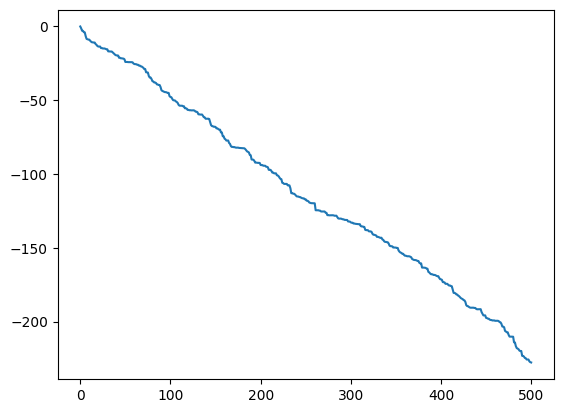

In [47]:
import matplotlib.pyplot as plt
plt.plot(kf_res['history']['log_likelihood'])
plt.show()

In [27]:
import numpy as np

class StateSpaceModel:
    """
    Basis for discrete space state models:
        x_{k+1} = f(x_{k}, theta) + q_{k+1}
        y_{k+1}     = h(x_{k+1}, theta) + r_{k+1}
        q_{k+1} ~ Normal(0, Q(theta))
        r_{k+1} ~ Normal(0, R(theta))
    """

    def __init__(self, d, m):
        self.d = d  # state dimension
        self.m = m  # observation dimension

    # Evolution and observation (deterministic)
    def f(self, x, theta=None):
        raise NotImplementedError

    def h(self, x, theta=None):
        raise NotImplementedError

    # Jacobians ( KF / EKF)
    def f_x(self, x, theta=None):
        raise NotImplementedError

    def h_x(self, x, theta=None):
        raise NotImplementedError

    # Covariances
    def Q(self, x=None, theta=None):
        raise NotImplementedError

    def R(self, x=None, theta=None):
        raise NotImplementedError

    # Prior
    def prior(self):
        """
        Returns (m0, P0) such that x0 ~ Normal(m0, P0)
        """
        raise NotImplementedError

    # Simulation
    def sample_process_noise(self, x=None, theta=None):
        return np.random.multivariate_normal(
            mean=np.zeros(self.d),
            cov=self.Q(x, theta)
        )

    def sample_observation_noise(self, x=None, theta=None):
        return np.random.multivariate_normal(
            mean=np.zeros(self.m),
            cov=self.R(x, theta)
        )

    def sample_transition(self, x, theta=None):
        return self.f(x, theta) + self.sample_process_noise(x, theta)

    def sample_observation(self, x, theta=None):
        return self.h(x, theta) + self.sample_observation_noise(x, theta)

    def simulate(self, T, theta=None):
        """
        Simulate a trajectory (X, Y)
        """
        X = np.zeros((T + 1, self.d))
        Y = np.zeros((T, self.m))

        m0, _ = self.prior()
        X[0] = m0

        for t in range(T):
            X[t + 1] = self.sample_transition(X[t], theta)
            Y[t] = self.sample_observation(X[t + 1], theta)

        return X, Y
    


class LinearGaussianSSM(StateSpaceModel):
    def __init__(self, m0, P0, A, H, Sigma, Gamma):
        A = np.atleast_2d(A)
        H = np.atleast_2d(H)

        super().__init__(d=A.shape[0], m=H.shape[0])

        self.m0 = np.atleast_1d(m0)
        self.P0 = np.atleast_2d(P0)

        self.A = A
        self.H = H
        self.Sigma = np.atleast_2d(Sigma)
        self.Gamma = np.atleast_2d(Gamma)

    # Evolution and observation (deterministic)
    def f(self, x, theta=None):
        return self.A @ x

    def h(self, x, theta=None):
        return self.H @ x

    # Jacobians
    def f_x(self, x=None, theta=None):
        return self.A

    def h_x(self, x=None, theta=None):
        return self.H

    # Covariances
    def Q(self, x=None, theta=None):
        return self.Sigma

    def R(self, x=None, theta=None):
        return self.Gamma

    # Prior
    def prior(self):
        return self.m0.copy(), self.P0.copy()


import numpy as np


class LotkaVolterraSSM(StateSpaceModel):
    """
    Discrete-time Lotka–Volterra model via Euler discretization.
    State: x = (prey, predator)
    """

    def __init__(
        self,
        alpha=1.0,
        beta=0.5,
        delta=0.5,
        gamma=1.0,
        dt=0.01,
        m0=np.array([1.0, 1.0]),
        P0=0.01 * np.eye(2),
        Sigma=1e-4 * np.eye(2),
        Gamma=1e-2 * np.eye(2),
        H=None,
    ):
        super().__init__(d=2, m=2 if H is None else H.shape[0])

        self.alpha = alpha
        self.beta = beta
        self.delta = delta
        self.gamma = gamma
        self.dt = dt

        self.m0 = np.asarray(m0)
        self.P0 = np.asarray(P0)

        self.Sigma = np.atleast_2d(Sigma)
        self.Gamma = np.atleast_2d(Gamma)

        self.H = np.eye(2) if H is None else np.atleast_2d(H)

    # ---------- Dynamics ----------
    def f(self, x, theta=None):
        x1, x2 = x
        dx1 = self.alpha * x1 - self.beta * x1 * x2
        dx2 = self.delta * x1 * x2 - self.gamma * x2
        return x + self.dt * np.array([dx1, dx2])

    def h(self, x, theta=None):
        return self.H @ x

    # ---------- Jacobians ----------
    def f_x(self, x, theta=None):
        x1, x2 = x
        J = np.array([
            [self.alpha - self.beta * x2, -self.beta * x1],
            [self.delta * x2, self.delta * x1 - self.gamma]
        ])
        return np.eye(2) + self.dt * J

    def h_x(self, x, theta=None):
        return self.H

    # ---------- Covariances ----------
    def Q(self, x=None, theta=None):
        return self.Sigma

    def R(self, x=None, theta=None):
        return self.Gamma

    # ---------- Prior ----------
    def prior(self):
        return self.m0.copy(), self.P0.copy()


class Lorenz63SSM(StateSpaceModel):
    """
    Discrete-time Lorenz-63 system via Euler discretization.
    """

    def __init__(
        self,
        sigma=10.0,
        rho=28.0,
        beta=8.0 / 3.0,
        dt=0.01,
        m0=np.array([1.0, 1.0, 1.0]),
        P0=0.01 * np.eye(3),
        Sigma=1e-4 * np.eye(3),
        Gamma=1e-2 * np.eye(3),
        H=None,
    ):
        super().__init__(d=3, m=3 if H is None else H.shape[0])

        self.sigma = sigma
        self.rho = rho
        self.beta = beta
        self.dt = dt

        self.m0 = np.asarray(m0)
        self.P0 = np.asarray(P0)

        self.Sigma = np.atleast_2d(Sigma)
        self.Gamma = np.atleast_2d(Gamma)

        self.H = np.eye(3) if H is None else np.atleast_2d(H)

    # ---------- Dynamics ----------
    def f(self, x, theta=None):
        x1, x2, x3 = x
        dx1 = self.sigma * (x2 - x1)
        dx2 = x1 * (self.rho - x3) - x2
        dx3 = x1 * x2 - self.beta * x3
        return x + self.dt * np.array([dx1, dx2, dx3])

    def h(self, x, theta=None):
        return self.H @ x

    # ---------- Jacobians ----------
    def f_x(self, x, theta=None):
        x1, x2, x3 = x
        J = np.array([
            [-self.sigma, self.sigma, 0.0],
            [self.rho - x3, -1.0, -x1],
            [x2, x1, -self.beta]
        ])
        return np.eye(3) + self.dt * J

    def h_x(self, x, theta=None):
        return self.H

    # ---------- Covariances ----------
    def Q(self, x=None, theta=None):
        return self.Sigma

    def R(self, x=None, theta=None):
        return self.Gamma

    # ---------- Prior ----------
    def prior(self):
        return self.m0.copy(), self.P0.copy()



In [28]:
import numpy as np

class BayesianFilter:
    """
    Clase base para filtros Bayesianos en modelos de espacio de estados.
    """

    def __init__(self, model, theta=None):
        self.model = model
        self.theta = theta

        self.m, self.P = model.prior()
        self.log_likelihood = 0.0

        self.history_m = []
        self.history_P = []
        self.history_ll = []

        self._store()

    def _store(self):
        self.history_m.append(None if self.m is None else self.m.copy())
        self.history_P.append(None if self.P is None else self.P.copy())
        self.history_ll.append(self.log_likelihood)

    def predict(self):
        raise NotImplementedError

    def update(self, y):
        raise NotImplementedError

    def filter(self, Y):
        for y in Y:
            self.predict()
            self.update(y)
            self._store()

        return {
            "filtering_mean": self.m,
            "filtering_cov": self.P,
            "particles": None,
            "weights": None,
            "log_likelihood": self.log_likelihood,
            "history": {
                "mean": self.history_m,
                "cov": self.history_P,
                "log_likelihood": self.history_ll
            }
        }

from scipy import linalg

class KalmanFilter(BayesianFilter):
    """
    Kalman Filter / Extended Kalman Filter
    """

    @staticmethod
    def log_gaussian_density(y, mu, S):
        d = len(y)
        diff = y - mu
        try:
            c, lower = linalg.cho_factor(S, check_finite=False)
            alpha = linalg.cho_solve((c, lower), diff)
            logdet = 2 * np.sum(np.log(np.diag(c)))
        except np.linalg.LinAlgError:
            alpha = np.linalg.solve(S, diff)
            logdet = np.log(np.linalg.det(S))

        return -0.5 * (diff @ alpha + logdet + d * np.log(2 * np.pi))

    def predict(self):
        F = self.model.f_x(self.m, self.theta)
        Q = self.model.Q(self.m, self.theta)

        self.m_minus = self.model.f(self.m, self.theta)
        self.P_minus = F @ self.P @ F.T + Q

    def update(self, y):
        H = self.model.h_x(self.m_minus, self.theta)
        R = self.model.R(self.m_minus, self.theta)

        mu = self.model.h(self.m_minus, self.theta)
        S = H @ self.P_minus @ H.T + R

        self.log_likelihood += self.log_gaussian_density(y, mu, S)

        try:
            c, lower = linalg.cho_factor(S, check_finite=False)
            S_inv = linalg.cho_solve((c, lower), np.eye(S.shape[0]))
        except np.linalg.LinAlgError:
            S_inv = np.linalg.inv(S)

        K = self.P_minus @ H.T @ S_inv
        innovation = y - mu

        self.m = self.m_minus + K @ innovation
        self.P = self.P_minus - K @ H @ self.P_minus

        # estabilidad numérica
        self.P = 0.5 * (self.P + self.P.T)
        self.P += 1e-8 * np.eye(self.P.shape[0])

import numpy as np
from scipy import linalg


class UnscentedKalmanFilter(BayesianFilter):
    """
    Unscented Kalman Filter genérico para StateSpaceModel
    """

    def __init__(self, model, theta=None,
                 alpha=1e-3, beta=2.0, kappa=0.0):

        super().__init__(model, theta)

        self.d = model.d
        self.m_obs = model.m

        # parámetros UKF
        self.alpha = alpha
        self.beta = beta
        self.kappa = kappa

        self.lambd = alpha**2 * (self.d + kappa) - self.d
        self.denom = self.d + self.lambd
        self.sqrt_d_lamb = np.sqrt(self.denom)

        self.w0m = self.lambd / self.denom
        self.w0c = self.w0m + (1.0 - alpha**2 + beta)
        self.wim = 1.0 / (2.0 * self.denom)

    # --------------------------------------------------
    @staticmethod
    def log_gaussian_density(y, mu, S):
        d = len(y)
        diff = y - mu
        try:
            c, lower = linalg.cho_factor(S, check_finite=False)
            alpha = linalg.cho_solve((c, lower), diff)
            logdet = 2 * np.sum(np.log(np.diag(c)))
        except np.linalg.LinAlgError:
            alpha = np.linalg.solve(S, diff)
            logdet = np.log(np.linalg.det(S))

        return -0.5 * (diff @ alpha + logdet + d * np.log(2 * np.pi))

    # --------------------------------------------------
    def _sigma_points(self, m, P):
        try:
            A = np.linalg.cholesky(P)
        except np.linalg.LinAlgError:
            A = np.linalg.cholesky(P + 1e-8 * np.eye(self.d))

        X = np.empty((self.d, 2 * self.d + 1))
        X[:, 0] = m

        for i in range(self.d):
            col = A[:, i]
            X[:, 1 + i] = m + self.sqrt_d_lamb * col
            X[:, 1 + self.d + i] = m - self.sqrt_d_lamb * col

        return X

    # --------------------------------------------------
    def predict(self):
        X = self._sigma_points(self.m, self.P)

        X_hat = np.zeros_like(X)
        for i in range(2 * self.d + 1):
            X_hat[:, i] = self.model.f(X[:, i], self.theta)

        m_minus = (
            self.w0m * X_hat[:, 0]
            + self.wim * np.sum(X_hat[:, 1:], axis=1)
        )

        P_minus = self.model.Q(m_minus, self.theta).astype(float)
        for i in range(2 * self.d + 1):
            diff = X_hat[:, i] - m_minus
            w = self.w0c if i == 0 else self.wim
            P_minus += w * np.outer(diff, diff)

        self.m_minus = m_minus
        self.P_minus = 0.5 * (P_minus + P_minus.T)

    # --------------------------------------------------
    def update(self, y):
        X = self._sigma_points(self.m_minus, self.P_minus)

        Y_hat = np.zeros((self.m_obs, 2 * self.d + 1))
        for i in range(2 * self.d + 1):
            Y_hat[:, i] = self.model.h(X[:, i], self.theta)

        mu = (
            self.w0m * Y_hat[:, 0]
            + self.wim * np.sum(Y_hat[:, 1:], axis=1)
        )

        S = self.model.R(self.m_minus, self.theta).astype(float)
        for i in range(2 * self.d + 1):
            dy = Y_hat[:, i] - mu
            w = self.w0c if i == 0 else self.wim
            S += w * np.outer(dy, dy)

        S = 0.5 * (S + S.T)

        self.log_likelihood += self.log_gaussian_density(y, mu, S)

        C = np.zeros((self.d, self.m_obs))
        for i in range(2 * self.d + 1):
            dx = X[:, i] - self.m_minus
            dy = Y_hat[:, i] - mu
            w = self.w0c if i == 0 else self.wim
            C += w * np.outer(dx, dy)

        try:
            cho = np.linalg.cholesky(S)
            K = linalg.cho_solve((cho, True), C.T).T
        except np.linalg.LinAlgError:
            K = C @ np.linalg.inv(S)

        self.m = self.m_minus + K @ (y - mu)
        self.P = self.P_minus - K @ C.T
        self.P = 0.5 * (self.P + self.P.T)




from scipy.special import logsumexp


class ParticleFilter(BayesianFilter):
    """
    Particle Filter genérico para StateSpaceModel
    """

    def __init__(self, model, N, theta=None, resample_threshold=0.5):
        super().__init__(model, theta)

        self.N = N
        self.resample_threshold = resample_threshold

        self.d = model.d
        self.m_obs = model.m

        # inicialización de partículas desde el prior
        m0, P0 = model.prior()
        self.particles = np.random.multivariate_normal(
            mean=m0, cov=P0, size=N
        )

        self.logw = np.zeros(N) - np.log(N)

    # --------------------------------------------------
    @staticmethod
    def log_gaussian_density(y, mu, S):
        d = len(y)
        diff = y - mu
        try:
            c = np.linalg.cholesky(S)
            alpha = np.linalg.solve(c.T, np.linalg.solve(c, diff))
            logdet = 2 * np.sum(np.log(np.diag(c)))
        except np.linalg.LinAlgError:
            alpha = np.linalg.solve(S, diff)
            logdet = np.log(np.linalg.det(S))

        return -0.5 * (diff @ alpha + logdet + d * np.log(2 * np.pi))

    # --------------------------------------------------
    def predict(self):
        for i in range(self.N):
            self.particles[i] = self.model.sample_transition(
                self.particles[i], self.theta
            )

    # --------------------------------------------------
    def update(self, y):
        logw_new = np.zeros(self.N)

        R = self.model.R(None, self.theta)

        for i in range(self.N):
            y_pred = self.model.h(self.particles[i], self.theta)
            logw_new[i] = self.logw[i] + self.log_gaussian_density(
                y, y_pred, R
            )

        # normalización estable
        logZ = logsumexp(logw_new)
        self.logw = logw_new - logZ
        self.log_likelihood += logZ

    # --------------------------------------------------
    def effective_sample_size(self):
        w = np.exp(self.logw)
        return 1.0 / np.sum(w**2)

    # --------------------------------------------------
    def resample(self):
        w = np.exp(self.logw)
        idx = np.random.choice(self.N, size=self.N, p=w)

        self.particles = self.particles[idx]
        self.logw[:] = -np.log(self.N)

    # --------------------------------------------------
    def estimate(self):
        w = np.exp(self.logw)

        mean = np.sum(self.particles * w[:, None], axis=0)

        diff = self.particles - mean
        cov = diff.T @ (diff * w[:, None])

        self.m = mean
        self.P = 0.5 * (cov + cov.T)

    # --------------------------------------------------
    def update_step(self, y):
        self.predict()
        self.update(y)

        if self.effective_sample_size() < self.resample_threshold * self.N:
            self.resample()

        self.estimate()


In [29]:
A = np.array([[1.0, 0.1],
              [0.0, 1.0]])
H = np.array([[1.0, 0.0]])
Sigma = 0.001 * np.eye(2)
Gamma = 0.01 * np.eye(1)
m0 = np.zeros(2)
P0 = np.eye(2)

model = LinearGaussianSSM(
    m0=m0,
    P0=P0,
    A=A,
    H=H,
    Sigma=Sigma,
    Gamma=Gamma
)

kf = KalmanFilter(model)
ukf = UnscentedKalmanFilter(model)
pf = ParticleFilter(model, N=50000)


X_true, Y = model.simulate(T=10)

import time

t0 = time.time()
res_kf = kf.filter(Y)
kf_time = time.time() - t0

t0 = time.time()
res_ukf = ukf.filter(Y)
ukf_time = time.time() - t0

t0 = time.time()
res_pf = pf.filter(Y)
pf_time = time.time() - t0

def rmse(x_hat, x_true):
    return np.sqrt(np.mean((x_hat - x_true)**2))

kf_rmse = rmse(res_kf["filtering_mean"][0], X_true[-1])
ukf_rmse = rmse(res_ukf["filtering_mean"][0], X_true[-1])
pf_rmse = rmse(res_pf["filtering_mean"][0], X_true[-1])

kf_ll = res_kf["log_likelihood"]
ukf_ll = res_ukf["log_likelihood"]
pf_ll = res_pf["log_likelihood"]

print("\n=== COMPARACIÓN DE FILTROS (MODELO LINEAL) ===\n")

print(f"KF  | RMSE: {kf_rmse:.5f} | logL: {kf_ll:.5f} | time: {kf_time:.3f}s")
print(f"UKF | RMSE: {ukf_rmse:.5f} | logL: {ukf_ll:.5f} | time: {ukf_time:.3f}s")
print(f"PF  | RMSE: {pf_rmse:.5f} | logL: {pf_ll:.5f} | time: {pf_time:.3f}s")




=== COMPARACIÓN DE FILTROS (MODELO LINEAL) ===

KF  | RMSE: 0.02374 | logL: 4.22893 | time: 0.002s
UKF | RMSE: 0.02374 | logL: 4.22893 | time: 0.008s
PF  | RMSE: 0.05111 | logL: 4.26383 | time: 72.693s


In [30]:
import time
import numpy as np


def run_experiment(model, T, pf_particles=20000):
    # Simulación
    X_true, Y = model.simulate(T)

    # Filtros
    kf = KalmanFilter(model)
    ukf = UnscentedKalmanFilter(model)
    pf = ParticleFilter(model, N=pf_particles)

    # KF
    t0 = time.time()
    res_kf = kf.filter(Y)
    kf_time = time.time() - t0

    # UKF
    t0 = time.time()
    res_ukf = ukf.filter(Y)
    ukf_time = time.time() - t0

    # PF
    t0 = time.time()
    res_pf = pf.filter(Y)
    pf_time = time.time() - t0

    def rmse(x_hat, x_true):
        return np.sqrt(np.mean((x_hat - x_true)**2))

    results = {
        "KF": {
            "rmse": rmse(res_kf["filtering_mean"], X_true[-1]),
            "logL": res_kf["log_likelihood"],
            "time": kf_time,
        },
        "UKF": {
            "rmse": rmse(res_ukf["filtering_mean"], X_true[-1]),
            "logL": res_ukf["log_likelihood"],
            "time": ukf_time,
        },
        "PF": {
            "rmse": rmse(res_pf["filtering_mean"], X_true[-1]),
            "logL": res_pf["log_likelihood"],
            "time": pf_time,
        },
        "X_true": X_true,
        "Y": Y,
        "results": {
            "KF": res_kf,
            "UKF": res_ukf,
            "PF": res_pf,
        }
    }
    
    print(f"KF  | RMSE: {results['KF']['rmse']:.5f} | logL: {results['KF']['logL']:.5f} | time: {kf_time:.3f}s")
    print(f"UKF | RMSE: {results['UKF']['rmse']:.5f} | logL: {results['UKF']['logL']:.5f} | time: {ukf_time:.3f}s")
    print(f"PF  | RMSE: {results['PF']['rmse']:.5f} | logL: {results['PF']['logL']:.5f} | time: {pf_time:.3f}s")


    return results



In [32]:

model_lv = LotkaVolterraSSM(
    alpha=1.5,
    beta=1.0,
    delta=1.0,
    gamma=3.0,
    dt=0.01,
    m0=np.array([1.0, 0.5]),
    P0=0.05 * np.eye(2),
    Sigma=1e-4 * np.eye(2),
    Gamma=1e-2 * np.eye(2)
)

res_lv = run_experiment(model_lv, T=20, pf_particles=5000)


KF  | RMSE: 0.02550 | logL: 28.29481 | time: 0.005s
UKF | RMSE: 0.02550 | logL: 28.29480 | time: 0.019s
PF  | RMSE: 0.20050 | logL: 28.29152 | time: 18.138s


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

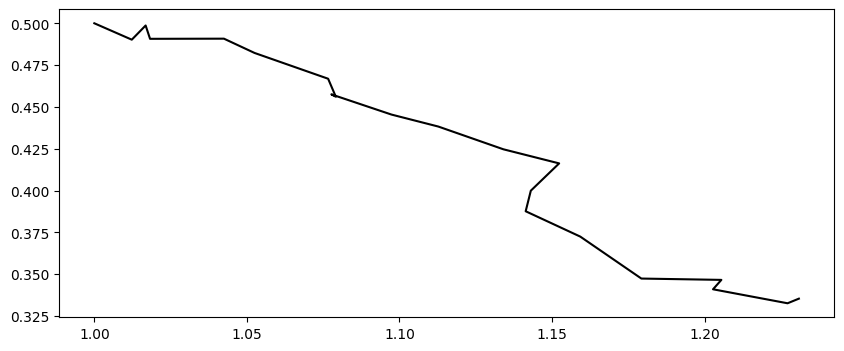

In [33]:
import matplotlib.pyplot as plt

X = res_lv["X_true"]
X_kf = res_lv["results"]["KF"]["filtering_mean"]
X_ukf = res_lv["results"]["UKF"]["filtering_mean"]
X_pf = res_lv["results"]["PF"]["filtering_mean"]

plt.figure(figsize=(10,4))
plt.plot(X[:,0], X[:,1], 'k-', label="True")
plt.plot(X_kf[:,0], X_kf[:,1], '--', label="KF")
plt.plot(X_ukf[:,0], X_ukf[:,1], '--', label="UKF")
plt.plot(X_pf[:,0], X_pf[:,1], '--', label="PF")
plt.legend()
plt.title("Lotka–Volterra phase space")
plt.show()


In [36]:

model_l63 = Lorenz63SSM(
    sigma=10.0,
    rho=28.0,
    beta=8/3,
    dt=0.005,
    m0=np.array([1.0, 1.0, 1.0]),
    P0=0.1 * np.eye(3),
    Sigma=5e-4 * np.eye(3),
    Gamma=1e-2 * np.eye(3)
)

res_l63 = run_experiment(model_l63, T=10, pf_particles=500)


KF  | RMSE: 0.04221 | logL: 22.73729 | time: 0.003s
UKF | RMSE: 0.04221 | logL: 22.73736 | time: 0.010s
PF  | RMSE: 0.75528 | logL: 23.08343 | time: 1.015s
